In [8]:
import pyuvdata
import numpy as np
import sys
sys.path.append("/Users/ruby/Astro/rlb_LWA/beam_manipulation")
import jones_to_mueller
import importlib
importlib.reload(jones_to_mueller)
import matplotlib
import matplotlib.pyplot as plt
import math

In [2]:
#beam_path = "/Users/ruby/Astro/Nivedita_beams/LWA_10to100.beamfits"
beam_path = "/Users/ruby/Astro/Nivedita_beams/LWA_10to100_MROsoil_efields.fits"
beam = pyuvdata.UVBeam()
beam.read(beam_path)
beam.select(axis2_inds=np.where(beam.axis2_array <= np.pi/2)[0])
beam.peak_normalize()

In [3]:
# Beam manipulations
beam_radec = jones_to_mueller.pol_basis_transform_azza_to_radec(beam, latitude=37.23, inplace=False)
mueller_coherency = jones_to_mueller.convert_jones_to_mueller(beam_radec)
mueller_stokes = jones_to_mueller.pol_basis_transform_radec_to_stokes(mueller_coherency, inplace=False)
mueller_pstokes = jones_to_mueller.pol_basis_transform_instrumental_to_pseudostokes(mueller_stokes)

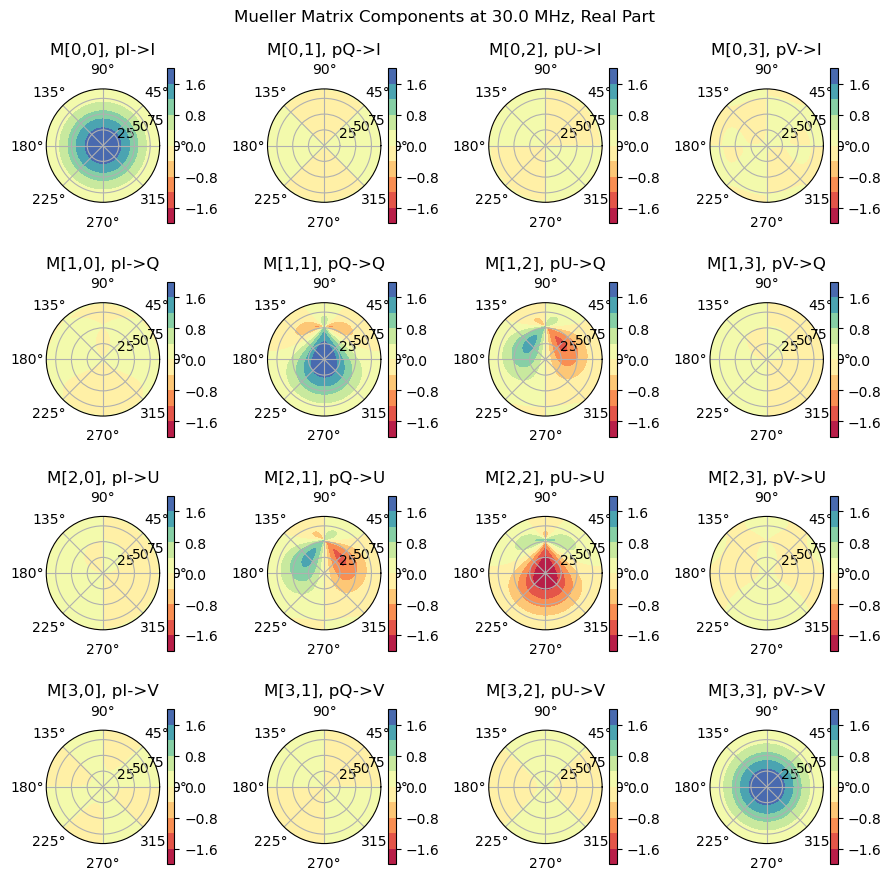

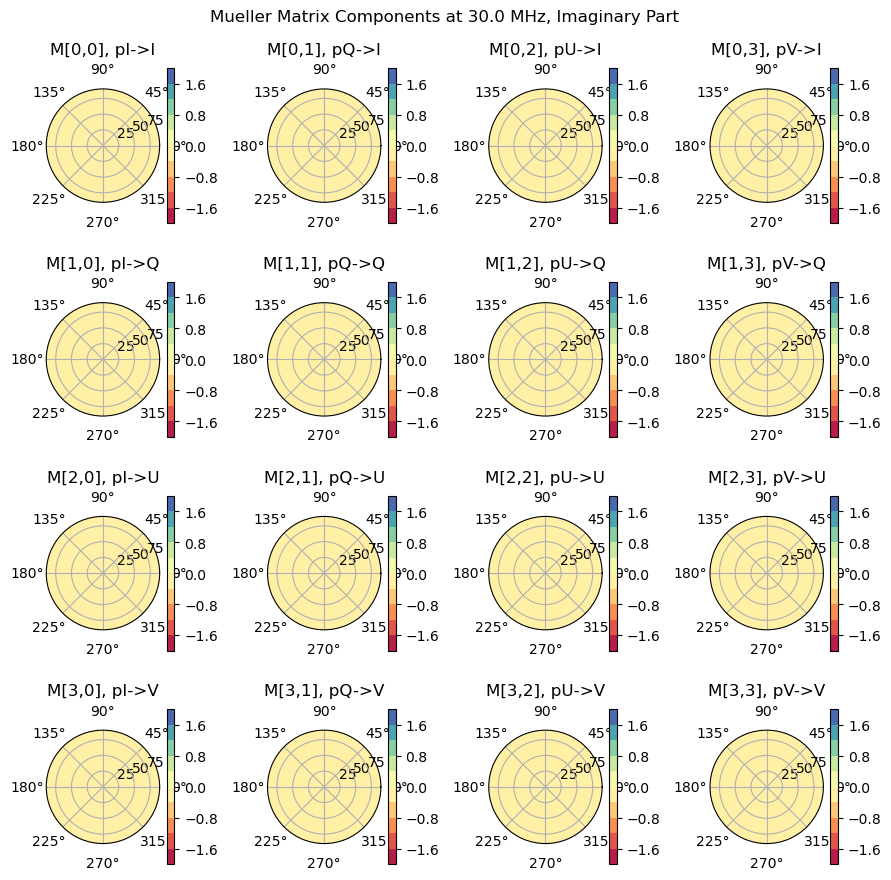

In [68]:
jones_to_mueller.plot_mueller_matrix(
    mueller_pstokes,  # pyuvdata beam object
    np.degrees(beam_radec.axis1_array),
    np.degrees(beam_radec.axis2_array),
    beam_radec.freq_array,
    plot_freq=30.0e6,  # frequency in Hz, must be included in the beam obj
    real_part=True,
    contour_plot=True,
    stokes=True,
    pseudostokes=True,
    vmin=-2,
    vmax=2,
)
jones_to_mueller.plot_mueller_matrix(
    mueller_pstokes,  # pyuvdata beam object
    np.degrees(beam_radec.axis1_array),
    np.degrees(beam_radec.axis2_array),
    beam_radec.freq_array,
    plot_freq=30.0e6,  # frequency in Hz, must be included in the beam obj
    real_part=False,
    contour_plot=True,
    stokes=True,
    pseudostokes=True,
    vmin=-2,
    vmax=2,
)

In [69]:
np.shape(mueller_pstokes)

(4, 1, 4, 91, 91, 361)

In [6]:
beam.Nfreqs

91

In [61]:
def zernike(n, m, za, az):

    if n == m == 0:
        return np.full_like(za, 1)
    
    rho = np.sin(za)
    zernike_r = 0
    if (n-m)%2 == 0:
        for k in range(int((n-m)/2)):
            zernike_r += (-1)**k * math.factorial(n-k) / (
                math.factorial(k) * math.factorial(int((n+m)/2) - k) * math.factorial(int((n-m)/2) - k)
            ) * rho ** (n - 2 * k)
    if m >= 0:
        value = zernike_r * np.cos(m * az)
    else:
        value = zernike_r * np.sin(np.abs(m) * az)

    # This was included in Michael's code, I'm not sure if it's needed
    negative_values = np.where(value < 0)
    if len(negative_values[0]) > 0:
        value[negative_values] = 0.0

    return value

In [62]:
zernike(4, 0, np.array([0,0.1,0.2]), np.array([0, np.pi/2, np.pi]))

array([0., 0., 0.])

In [63]:
def create_zernike_beam(az_values, za_values, zernike_coeffs, n_vals, m_vals):
    beam = np.zeros_like(az_values)
    for zernike_ind, coeff in enumerate(zernike_coeffs):
        beam += coeff * zernike(n_vals[zernike_ind], m_vals[zernike_ind], np.radians(za_values), np.radians(az_values))
    return beam

In [66]:
az_axis = np.degrees(beam_radec.axis1_array)
za_axis = np.degrees(beam_radec.axis2_array)
za_vals, az_vals = np.meshgrid(za_axis, az_axis)
n_vals = [0, 2, 4, 4, 6, 6, 8, 8, 8]
m_vals = [0, 0, 0, 4, 0, 4, 0, 4, 8]
coeffs_52MHz = [ 
    0.5648697259136155,
    -0.45908927749490525,
    -0.03752995939112614,
    0.0033934821314708244,
    -0.030484384773088687,
    0.012225490320833442,
    -0.016913428790483902,  
    -0.004324269518531433,
    -0.013275940628521119,
]
coeffs_36MHz = [
    0.538556463745644,     -0.46866163121041965,
    -0.02903632892950315,   -0.008211454946665317,
    -0.02455123886166189,    0.010200717351278811,
    -0.002733004888223435,   0.012097962867146641,
    -0.010822907679258361
]
michael_beam = create_zernike_beam(az_vals, za_vals, coeffs_36MHz, n_vals, m_vals)

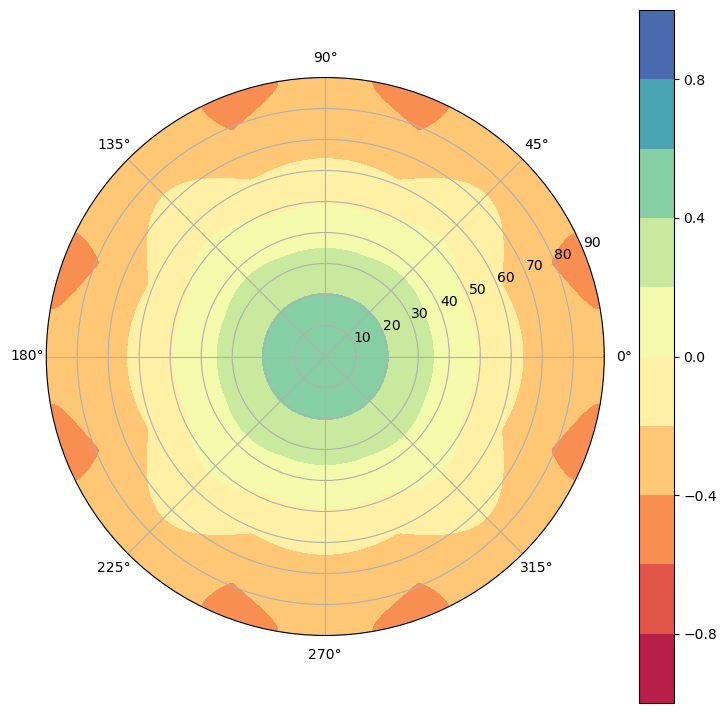

In [67]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, subplot_kw=dict(projection="polar"), figsize=(9, 9)
)
contourplot = jones_to_mueller.make_polar_contour_plot(
    ax,
    michael_beam,
    np.radians(az_vals),
    za_vals,
)
fig.colorbar(contourplot, ax=ax)
plt.show()

In [ ]:
def zernike_michael(n, m, ρ, θ):
    zernike_radial_part_michael(n, abs(m), ρ) * zernike_azimuthal_part_michael(m, θ)

def zernike_radial_part_michael(n, m, ρ)
    R0 = ρ^m
    n == m && return R0
    R2 = ((m+2)*ρ^2 - (m+1))*R0
    for n′ = m+4:2:n
        recurrence_relation = ((2*(n′-1)*(2n′*(n′-2)*ρ^2-m^2-n′*(n′-2))*R2 - n′*(n′+m-2)*(n′-m-2)*R0)
                                    / ((n′+m)*(n′-m)*(n′-2)))
        R0 = R2
        R2 = recurrence_relation
    end
    R2


def zernike_azimuthal_part_michael(m, θ)
    if m == 0:
        return 1.0
    elif m > 0:
        return cos(m*θ)
    else:
        return sin(-m*θ)
